# Calculate wind correlations at all Arctic points

* **Description**: Reads in and creates spatial plots of wind trends
* **Input data**: CESM2-LE and Rufmod output in timeseries format
* **Output data**: PNG figures of trends
* **Creator**: Alice DuVivier
* **Date**: August 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
from datetime import timedelta
import glob

import pop_tools

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec

import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import geocat.comp as gcomp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t

import dask
import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# spin up dask cluster

import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

<Client: 'tcp://10.12.206.63:43055' processes=0 threads=0, memory=0 B>

## Manually set variables

In [4]:
# list the variables to load
var_in_1 = 'U10'
var_in_2 = 'ICEFRAC'

## Load rufmod experiments

In [5]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/atm/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/atm/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/atm/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/atm/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/atm/proc/tseries/month_1/'

In [6]:
%%time
#reading in files
print("loading "+var_in_1)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cam.h0.'+var_in_1+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cam.h0.'+var_in_1+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cam.h0.'+var_in_1+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cam.h0.'+var_in_1+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

print("loading "+var_in_2)   
ds1_2 = []
ds2_2 = []
ds3_2 = []
ds4_2 = []
ds5_2 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in_2+'.*.nc'))
ds1_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cam.h0.'+var_in_2+'.*.nc'))
ds2_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cam.h0.'+var_in_2+'.*.nc'))
ds3_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cam.h0.'+var_in_2+'.*.nc'))
ds4_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cam.h0.'+var_in_2+'.*.nc'))
ds5_2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')


loading U10
loading ICEFRAC
CPU times: user 892 ms, sys: 353 ms, total: 1.24 s
Wall time: 5.35 s


In [7]:
# concatenate them into a single array
futures_1 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')

futures_2 = xr.concat([ds1_2,ds2_2,ds3_2,ds4_2,ds5_2],dim='member_id')

In [8]:
# set member_id values
futures_1.member_id.values
futures_2.member_id.values

# assign member_id as coordinate array
futures_1.assign_coords({"member_id": futures_1.member_id.values})
futures_2.assign_coords({"member_id": futures_2.member_id.values})

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    ICEFRAC       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [9]:
futures_1

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: member_id, nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [10]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_1['time'] = futures_1.time_bnds.load().mean(dim='nbnd').sel(member_id=0)
futures_2['time'] = futures_2.time_bnds.load().mean(dim='nbnd').sel(member_id=0)

In [11]:
futures_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:  time interval endpoints

In [12]:
U10_rufmod = futures_1[var_in_1]
ICE_rufmod = futures_2[var_in_2]

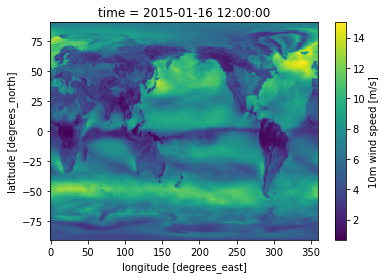

In [13]:
U10_rufmod.sel(member_id=0).isel(time=0).plot()

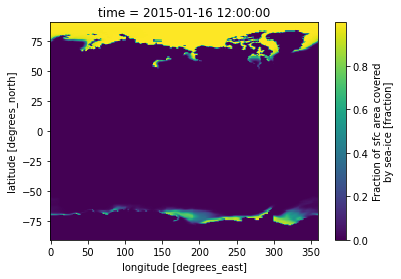

In [14]:
ICE_rufmod.sel(member_id=0).isel(time=0).plot()

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [15]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [16]:
forcing = 'cmip6'  # do not want smbb data
expt = 'ssp370'
comp = 'atm'
freq = 'month_1'

subset_1 = cat.search(variable=var_in_1, forcing_variant=forcing, experiment=expt, component=comp, frequency=freq )
subset_2 = cat.search(variable=var_in_2, forcing_variant=forcing, experiment=expt, component=comp, frequency=freq )


In [17]:
subset_1

In [18]:
subset_1.df.head()

component  stream                                     case    member_id  \
0       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
1       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
2       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
3       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
4       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   

  variable start_time end_time     time_range       long_name units  \
0      U10    2015-01  2024-12  201501-202412  10m wind speed   m/s   
1      U10    2025-01  2034-12  202501-203412  10m wind speed   m/s   
2      U10    2035-01  2044-12  203501-204412  10m wind speed   m/s   
3      U10    2045-01  2054-12  204501-205412  10m wind speed   m/s   
4      U10    2055-01  2064-12  205501-206412  10m wind speed   m/s   

   vertical_levels frequency  \
0              1.0   month_1   
1              1.0   month_1   
2              1.0   month_1   
3              1.0   month_1   
4              1.0   month_1   

                                                path experiment  \
0  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
1  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
2  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
3  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
4  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   

  forcing_variant  cesm_member_id  control_branch_year  \
0           cmip6        1001.001                 1001   
1           cmip6        1001.001                 1001   
2           cmip6        1001.001                 1001   
3           cmip6        1001.001                 1001   
4           cmip6        1001.001                 1001   

         cmip_experiment_id  
0  CESM2_ssp370_r1i1001p1f1  
1  CESM2_ssp370_r1i1001p1f1  
2  CESM2_ssp370_r1i1001p1f1  
3  CESM2_ssp370_r1i1001p1f1  
4  CESM2_ssp370_r1i1001p1f1

In [19]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_1.df.experiment.unique())
print(member_id)

['ssp370']


In [20]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})
    
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_2 = subset_2.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 16.5 s, sys: 469 ms, total: 16.9 s
Wall time: 31.3 s


In [21]:
# load in the future datasets
futures_1 = []
for key in sorted(dsets_1.keys()):
    futures_1.append(dsets_1[key])
    print(key)
    
futures_2 = []
for key in sorted(dsets_2.keys()):
    futures_2.append(dsets_2[key])
    print(key)
    

atm.ssp370.cam.h0.cmip6.U10
atm.ssp370.cam.h0.cmip6.ICEFRAC


In [22]:
future_ds_1 = xr.concat(futures_1, dim='member_id')
future_ds_2 = xr.concat(futures_2, dim='member_id')

In [23]:
future_ds_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [24]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
future_ds_1['time'] = future_ds_1.time_bnds.load().mean(dim='nbnd').sel(member_id='r1i1281p1f1')
future_ds_2['time'] = future_ds_2.time_bnds.load().mean(dim='nbnd').sel(member_id='r1i1281p1f1')

In [25]:
U10_le = future_ds_1[var_in_1]
ICE_le = future_ds_2[var_in_2]

In [26]:
U10_le.persist()
ICE_le.persist()

<xarray.DataArray 'ICEFRAC' (member_id: 50, time: 1032, lat: 192, lon: 288)>
dask.array<concatenate, shape=(50, 1032, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by sea-ice
    cell_methods:  time: mean

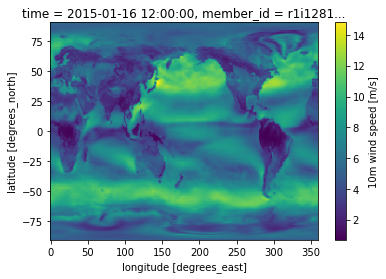

In [27]:
U10_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [28]:
U10_le

<xarray.DataArray 'U10' (member_id: 50, time: 1032, lat: 192, lon: 288)>
dask.array<concatenate, shape=(50, 1032, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

## Mask Arctic Ocean only

In [29]:
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/mask_plots/ATM_MASK_ArcOc.nc')


In [30]:
my_mask = ds_masks['atm_ArcOc_mask']

In [31]:
my_mask

<xarray.DataArray 'atm_ArcOc_mask' (lat: 192, lon: 288)>
dask.array<open_dataset-da90c46d10fd21b010e08c82e53c0a7aatm_ArcOc_mask, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

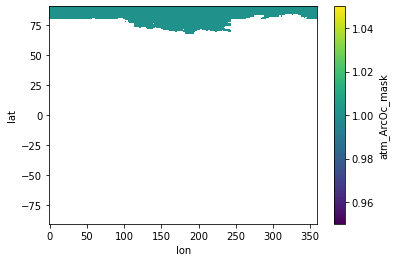

In [32]:
my_mask.plot()

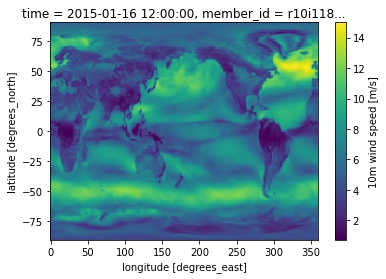

In [33]:
# check data
U10_le.isel(member_id=0,time=0).plot()

In [34]:
# set data lat/lon to equal those from mask, otherwise masking below doesn't work properly
U10_le['lat'] = my_mask['lat']
U10_le['lon'] = my_mask['lon']
ICE_le['lat'] = my_mask['lat']
ICE_le['lon'] = my_mask['lon']

U10_rufmod['lat'] = my_mask['lat']
U10_rufmod['lon'] = my_mask['lon']
ICE_rufmod['lat'] = my_mask['lat']
ICE_rufmod['lon'] = my_mask['lon']

In [35]:
# mask just NH cap
U10_masked_le = U10_le.where(my_mask==1)
ICE_masked_le = ICE_le.where(my_mask==1)
U10_masked_rufmod = U10_rufmod.where(my_mask==1)
ICE_masked_rufmod = ICE_rufmod.where(my_mask==1)

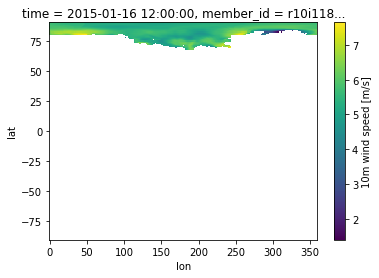

In [36]:
#just test that it worked properly
U10_masked_le.isel(member_id=0,time=0).plot()

## Load data

In [37]:
U10_masked_le.load()
ICE_masked_le.load()

<xarray.DataArray 'ICEFRAC' (member_id: 50, time: 1032, lat: 192, lon: 288)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [9.98036325e-01, 9.98028040e-01, 9.98021126e-01, ...,
          9.98043299e-01, 9.98040855e-01, 9.98040915e-01],
         [9.98573601e-01, 9.98545289e-01, 9.98516798e-01, ...,
          9.98657525e-01, 9.98632669e-01, 9.98603165e-01],
         [9.98870492e-01, 9.98869002e-01, 9.98867691e-01, ...,
          9.98875856e-01, 9.98873889e-01, 9.98872101e-01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
...
          1.65086348e-07, 1.38805902e-07, 1.02534791e-07],
         [1.34667516e-06, 1.35405571e-06, 1.35033315e-06, ...,
          1.31656248e-06, 1.33087531e-06, 1.33945832e-06],
         [1.26496911e-06, 1.27137923e-06, 1.27721819e-06, ...,
          1.24153098e-06, 1.25013605e-06, 1.25791598e-06]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [3.33158135e-01, 3.26452345e-01, 3.20145518e-01, ...,
          3.54135096e-01, 3.47062111e-01, 3.40268880e-01],
         [3.38118255e-01, 3.35117847e-01, 3.32013041e-01, ...,
          3.48025709e-01, 3.44437212e-01, 3.41197163e-01],
         [3.54303777e-01, 3.53757739e-01, 3.53258044e-01, ...,
          3.56285602e-01, 3.55560035e-01, 3.54902178e-01]]]],
      dtype=float32)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by sea-ice
    cell_methods:  time: mean

In [38]:
U10_masked_rufmod.load()
ICE_masked_rufmod.load()

<xarray.DataArray 'ICEFRAC' (member_id: 5, time: 1032, lat: 192, lon: 288)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [9.97029960e-01, 9.97001171e-01, 9.96974289e-01, ...,
          9.97110069e-01, 9.97082472e-01, 9.97056723e-01],
         [9.97592509e-01, 9.97583926e-01, 9.97574389e-01, ...,
          9.97624636e-01, 9.97612298e-01, 9.97601867e-01],
         [9.97844577e-01, 9.97843862e-01, 9.97843266e-01, ...,
          9.97847080e-01, 9.97846127e-01, 9.97845292e-01]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
...
          4.24798009e-06, 4.00754152e-06, 3.77753963e-06],
         [1.95029907e-06, 1.91859749e-06, 1.88235049e-06, ...,
          2.03381160e-06, 2.01117905e-06, 1.98166754e-06],
         [1.54931308e-06, 1.55027055e-06, 1.55110570e-06, ...,
          1.54558120e-06, 1.54698364e-06, 1.54822214e-06]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [3.32482182e-03, 2.66997400e-03, 2.11672857e-03, ...,
          5.72670577e-03, 4.85855620e-03, 4.13191086e-03],
         [2.04224908e-03, 1.83528825e-03, 1.62372633e-03, ...,
          2.92763207e-03, 2.51348084e-03, 2.25530006e-03],
         [1.45515148e-03, 1.44862465e-03, 1.44262658e-03, ...,
          1.47868553e-03, 1.47009129e-03, 1.46227912e-03]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: member_id
Attributes:
    units:         fraction
    long_name:     Fraction of sfc area covered by sea-ice
    cell_methods:  time: mean

## Calculate seasonal means

In [39]:
season_names = ['OND','JFM', 'AMJ', 'JAS']

In [40]:
# find total years
xarr_le = U10_masked_le.coords['time.year'][(U10_masked_le.coords['time.month']==1)]
xarr_rufmod = U10_masked_rufmod.coords['time.year'][(U10_masked_rufmod.coords['time.month']==1)]

In [41]:
# Loop through seasons - rufmod

# make numpy array to fill and specify dimensions we want
seas_array_rufmod_1 = np.zeros([len(season_names),len(xarr_rufmod),len(U10_masked_rufmod.member_id),len(U10_masked_rufmod.lat),len(U10_masked_rufmod.lon)])
seas_array_rufmod_2 = np.zeros([len(season_names),len(xarr_rufmod),len(U10_masked_rufmod.member_id),len(U10_masked_rufmod.lat),len(U10_masked_rufmod.lon)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1a = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([1,2,3]))
        temp1b = ICE_masked_rufmod.isel(time=ICE_masked_rufmod.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1a = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([4,5,6]))
        temp1b = ICE_masked_rufmod.isel(time=ICE_masked_rufmod.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1a = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([7,8,9]))
        temp1b = ICE_masked_rufmod.isel(time=ICE_masked_rufmod.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1a = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([10,11,12]))
        temp1b = ICE_masked_rufmod.isel(time=ICE_masked_rufmod.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_rufmod:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2a = temp1a.isel(time=temp1a.time.dt.year.isin([yy]))
        temp3a = temp2a.mean(dim='time')
        seas_array_rufmod_1[s_count,y_count,:,:,:] = temp3a 
        
        temp2b = temp1b.isel(time=temp1b.time.dt.year.isin([yy]))
        temp3b = temp2b.mean(dim='time')
        seas_array_rufmod_2[s_count,y_count,:,:,:] = temp3b   


OND
JFM
AMJ
JAS


In [42]:
# Loop through seasons - CESM2-LE

# make numpy array to fill and specify dimensions we want
seas_array_le_1 = np.zeros([len(season_names),len(xarr_le),len(U10_masked_le.member_id),len(U10_masked_le.lat),len(U10_masked_le.lon)])
seas_array_le_2 = np.zeros([len(season_names),len(xarr_le),len(U10_masked_le.member_id),len(U10_masked_le.lat),len(U10_masked_le.lon)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1a = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([1,2,3]))
        temp1b = ICE_masked_le.isel(time=ICE_masked_le.time.dt.month.isin([1,2,3]))        
    if ss == 'AMJ':
        temp1a = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([4,5,6]))
        temp1b = ICE_masked_le.isel(time=ICE_masked_le.time.dt.month.isin([4,5,6]))        
    if ss == 'JAS':
        temp1a = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([7,8,9]))
        temp1b = ICE_masked_le.isel(time=ICE_masked_le.time.dt.month.isin([7,8,9]))        
    if ss == 'OND':
        temp1a = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([10,11,12]))
        temp1b = ICE_masked_le.isel(time=ICE_masked_le.time.dt.month.isin([10,11,12]))        
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_le:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2a = temp1a.isel(time=temp1a.time.dt.year.isin([yy]))
        temp3a = temp2a.mean(dim='time')
        seas_array_le_1[s_count,y_count,:,:,:] = temp3a  

        temp2b = temp1b.isel(time=temp1b.time.dt.year.isin([yy]))
        temp3b = temp2b.mean(dim='time')
        seas_array_le_2[s_count,y_count,:,:,:] = temp3b  


OND
JFM
AMJ
JAS


In [43]:
print(seas_array_le_1.shape)
print(seas_array_rufmod_1.shape)
print(seas_array_le_2.shape)
print(seas_array_rufmod_2.shape)

(4, 86, 50, 192, 288)
(4, 86, 5, 192, 288)
(4, 86, 50, 192, 288)
(4, 86, 5, 192, 288)


In [44]:
# convert the numpy array to a xarray for easier plotting
U10_seas_le = xr.DataArray(seas_array_le_1,dims=('season','time','member_id','lat','lon'))
U10_seas_rufmod = xr.DataArray(seas_array_rufmod_1,dims=('season','time','member_id','lat','lon'))

ICE_seas_le = xr.DataArray(seas_array_le_2,dims=('season','time','member_id','lat','lon'))
ICE_seas_rufmod = xr.DataArray(seas_array_rufmod_2,dims=('season','time','member_id','lat','lon'))

In [45]:
# set coordinate arrays
U10_seas_le['season'] = season_names
U10_seas_le['time'] = xarr_le
U10_seas_le['member_id'] = U10_masked_le['member_id']
U10_seas_le['lat'] = U10_masked_le['lat'].values
U10_seas_le['lon'] = U10_masked_le['lon'].values

U10_seas_rufmod['season'] = season_names
U10_seas_rufmod['time'] = xarr_rufmod
U10_seas_rufmod['member_id'] = U10_masked_rufmod['member_id']
U10_seas_rufmod['lat'] = U10_masked_rufmod['lat'].values
U10_seas_rufmod['lon'] = U10_masked_rufmod['lon'].values

ICE_seas_le['season'] = season_names
ICE_seas_le['time'] = xarr_le
ICE_seas_le['member_id'] = U10_masked_le['member_id']
ICE_seas_le['lat'] = U10_masked_le['lat'].values
ICE_seas_le['lon'] = U10_masked_le['lon'].values

ICE_seas_rufmod['season'] = season_names
ICE_seas_rufmod['time'] = xarr_rufmod
ICE_seas_rufmod['member_id'] = U10_masked_rufmod['member_id']
ICE_seas_rufmod['lat'] = U10_masked_rufmod['lat'].values
ICE_seas_rufmod['lon'] = U10_masked_rufmod['lon'].values

## Calculate ensemble mean

In [46]:
# Calculate ensemble means
U10_seas_ens_mean_le = U10_seas_le.mean(dim='member_id')
U10_seas_ens_mean_rufmod = U10_seas_rufmod.mean(dim='member_id')

ICE_seas_ens_mean_le = ICE_seas_le.mean(dim='member_id')
ICE_seas_ens_mean_rufmod = ICE_seas_rufmod.mean(dim='member_id')

In [47]:
ICE_seas_ens_mean_rufmod

<xarray.DataArray (season: 4, time: 86, lat: 192, lon: 288)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.99336485, 0.99325998, 0.99315633, ..., 0.99362854,
          0.99354242, 0.99345804],
         [0.99430379, 0.99426191, 0.9942162 , ..., 0.99444823,
          0.99439522, 0.99434786],
         [0.99435714, 0.99435438, 0.99435183, ..., 0.99436737,
          0.99436361, 0.99436021]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [0.01753754, 0.01740114, 0.01727591, ..., 0.01791193,
          0.0177884 , 0.01767178],
         [0.01898331, 0.01891574, 0.01884631, ..., 0.01921592,
          0.01913094, 0.01905452],
         [0.02069319, 0.02067021, 0.02064928, ..., 0.02077716,
          0.02074633, 0.02071846]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [0.01607844, 0.01594523, 0.01581958, ..., 0.01643741,
          0.01631859, 0.01620651],
         [0.01655599, 0.01653214, 0.01650465, ..., 0.01660836,
          0.01659981, 0.01657948],
         [0.01650639, 0.01650407, 0.01650193, ..., 0.01651469,
          0.01651167, 0.01650891]]]])
Coordinates:
  * season   (season) <U3 'OND' 'JFM' 'AMJ' 'JAS'
  * time     (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

## Subset points by dates

In [48]:
# Choose entire time period: 2020-2100
ind_st = 5
ind_ed = 85

print(U10_seas_ens_mean_le.time[ind_st:ind_ed])

<xarray.DataArray 'time' (time: 80)>
array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
       2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055,
       2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067,
       2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])
Coordinates:
  * time     (time) int64 2020 2021 2022 2023 2024 ... 2095 2096 2097 2098 2099


In [49]:
U10_all_le = U10_seas_ens_mean_le[:,ind_st:ind_ed,:,:]
ICE_all_le = ICE_seas_ens_mean_le[:,ind_st:ind_ed,:,:]

U10_all_rufmod = U10_seas_ens_mean_rufmod[:,ind_st:ind_ed,:,:]
ICE_all_rufmod = ICE_seas_ens_mean_rufmod[:,ind_st:ind_ed,:,:]

## Calculate correlations

In [50]:
# double check the arrays we need shapes
print(U10_all_le.shape)
print(ICE_all_le.shape)

print(U10_all_rufmod.shape)
print(ICE_all_rufmod.shape)


(4, 80, 192, 288)
(4, 80, 192, 288)
(4, 80, 192, 288)
(4, 80, 192, 288)


In [51]:
# calculate correlations - whole period
corr_u10_ice_le = xr.corr(U10_all_le,ICE_all_le,dim='time')
corr_u10_ice_rufmod = xr.corr(U10_all_rufmod,ICE_all_rufmod,dim='time')

## Now Plot correlations!

In [52]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

Plotting correlations for OND
Plotting correlations for JFM
Plotting correlations for AMJ
Plotting correlations for JAS


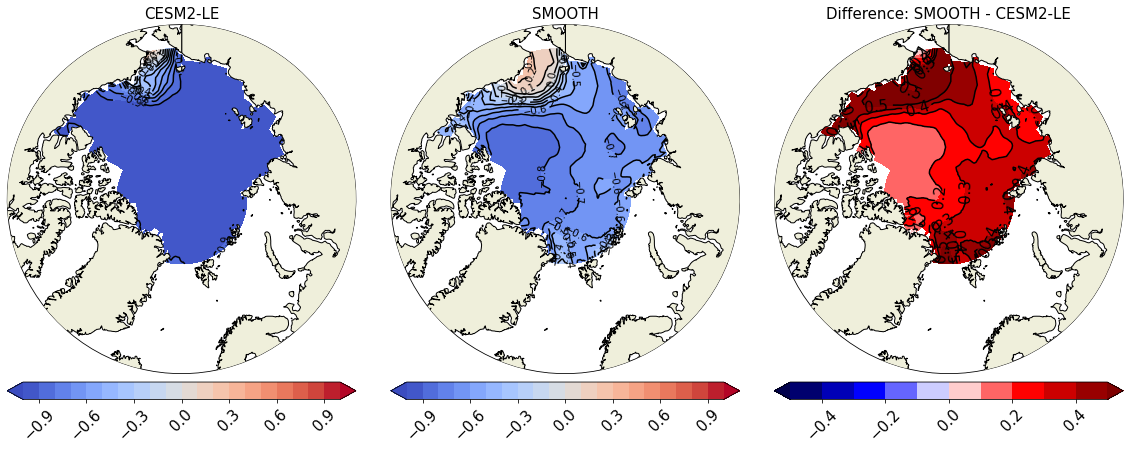

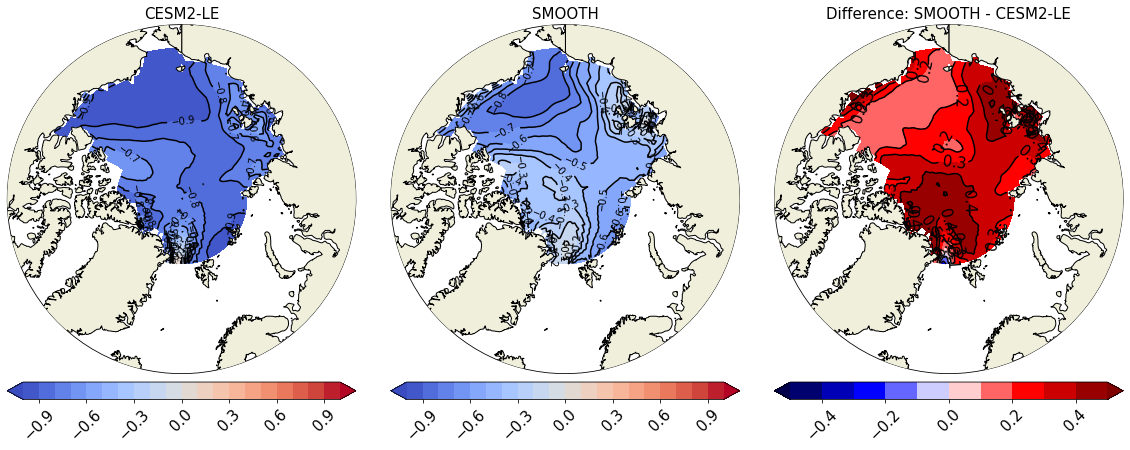

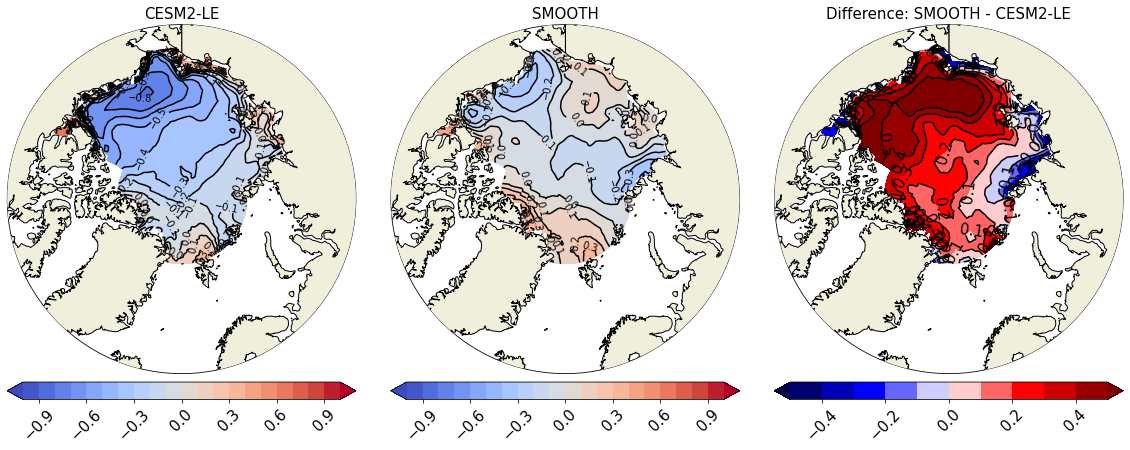

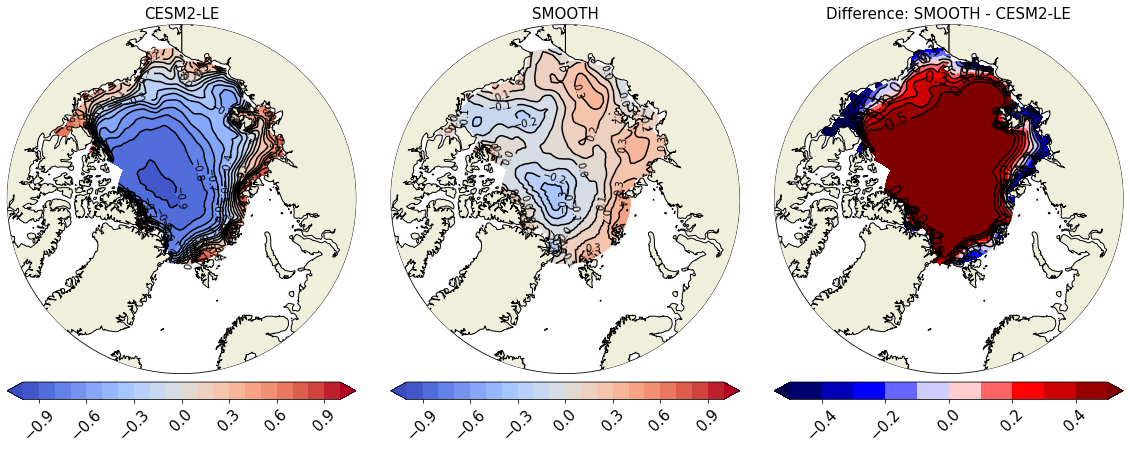

In [54]:
# set units
units = ' '

#Plot each season and percent difference
levels_in = np.arange(-1,1.1,0.1)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-0.5,0.6,0.1)
cmap_diff = plt.cm.get_cmap('seismic')

for ss in season_names:
    print('Plotting correlations for '+ss)

    # grab data we want
    corr_u_ice_le = corr_u10_ice_le.sel(season=ss)
    corr_u_ice_rufmod = corr_u10_ice_rufmod.sel(season=ss)
    
    # add cyclic point
    corr_u_ice_le = gvutil.xr_add_cyclic_longitudes(corr_u_ice_le,"lon")
    corr_u_ice_rufmod = gvutil.xr_add_cyclic_longitudes(corr_u_ice_rufmod,"lon")
    
    # calcualate difference
    diff = corr_u_ice_rufmod - corr_u_ice_le

    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+var_in_1+'_correlations_2020_2100_'+ss
    title = ss+' correlations over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE U10/ICE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(corr_u_ice_le.lon,corr_u_ice_le.lat,
                       corr_u_ice_le,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(corr_u_ice_le.lon,corr_u_ice_le.lat,
                       corr_u_ice_le,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # title
    plt.title('CESM2-LE',fontsize=15)

    # Second subplot: Rufmod U10/ICE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(corr_u_ice_rufmod.lon,corr_u_ice_rufmod.lat,
                       corr_u_ice_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(corr_u_ice_rufmod.lon,corr_u_ice_rufmod.lat,
                       corr_u_ice_rufmod,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # title
    plt.title('SMOOTH',fontsize=15)
    
    # Third subplot: difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=15, colors='black')
    # title
    plt.title('Difference: SMOOTH - CESM2-LE',fontsize=15)
    
    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.93)  
    fig.subplots_adjust(bottom=0.3,wspace=0.1)
    #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200) 


Plotting correlations for OND
Plotting correlations for JFM
Plotting correlations for AMJ
Plotting correlations for JAS


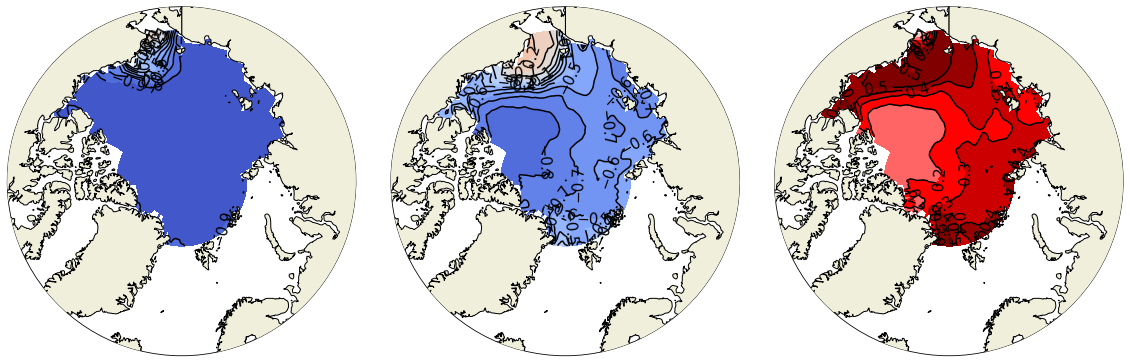

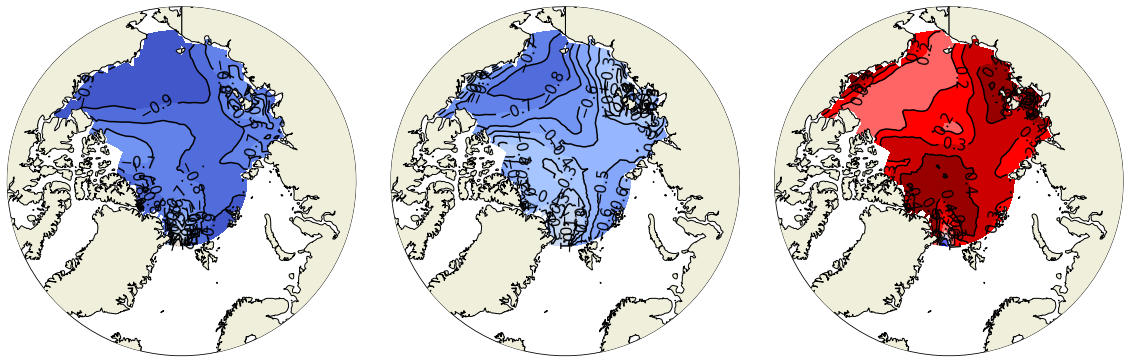

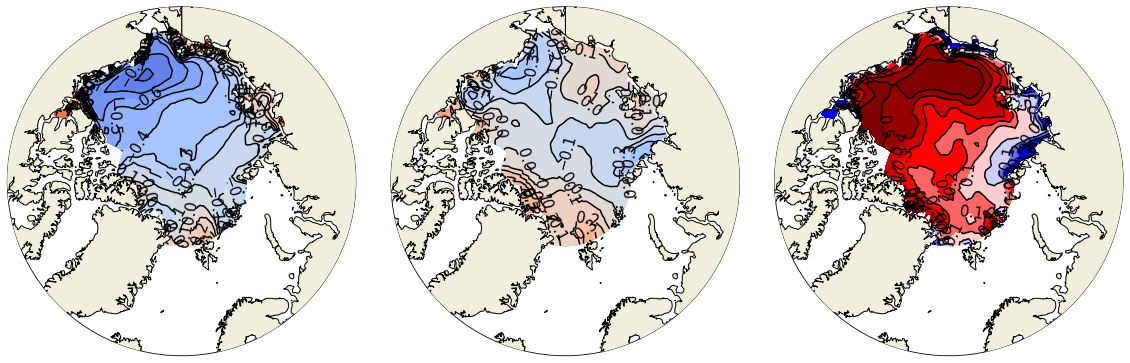

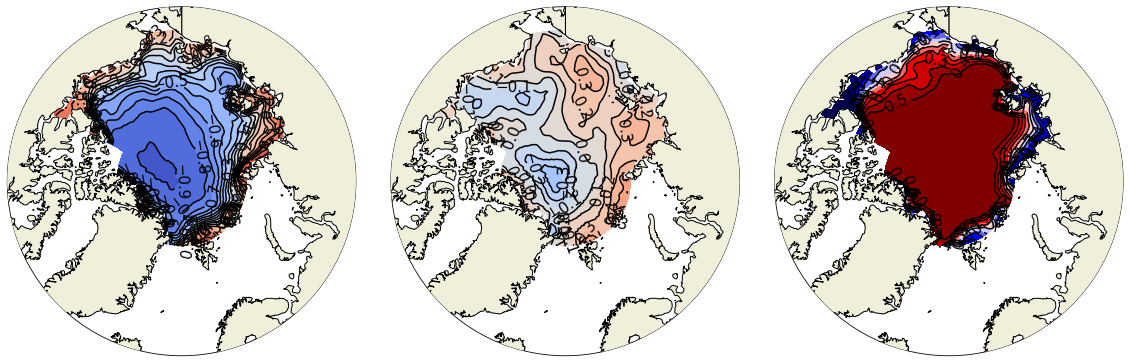

In [57]:
# set units
units = ' '

#Plot each season and percent difference
levels_in = np.arange(-1,1.1,0.1)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-0.5,0.6,0.1)
cmap_diff = plt.cm.get_cmap('seismic')

for ss in season_names:
    print('Plotting correlations for '+ss)

    # grab data we want
    corr_u_ice_le = corr_u10_ice_le.sel(season=ss)
    corr_u_ice_rufmod = corr_u10_ice_rufmod.sel(season=ss)
    
    # add cyclic point
    corr_u_ice_le = gvutil.xr_add_cyclic_longitudes(corr_u_ice_le,"lon")
    corr_u_ice_rufmod = gvutil.xr_add_cyclic_longitudes(corr_u_ice_rufmod,"lon")
    
    # calcualate difference
    diff = corr_u_ice_rufmod - corr_u_ice_le

    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'fig_13_'+var_in_1+'_correlations_2020_2100_'+ss
    title = ss+' correlations over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE U10/ICE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(corr_u_ice_le.lon,corr_u_ice_le.lat,
                       corr_u_ice_le,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    #cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    #cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(corr_u_ice_le.lon,corr_u_ice_le.lat,
                       corr_u_ice_le,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=15, colors='black')
    # title
    #plt.title('CESM2-LE',fontsize=15)

    # Second subplot: Rufmod U10/ICE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(corr_u_ice_rufmod.lon,corr_u_ice_rufmod.lat,
                       corr_u_ice_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    #cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    #cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(corr_u_ice_rufmod.lon,corr_u_ice_rufmod.lat,
                       corr_u_ice_rufmod,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=15, colors='black')
    # title
    #plt.title('SMOOTH',fontsize=15)
    
    # Third subplot: difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    #cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    #cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=15, colors='black')
    # title
    #plt.title('Difference: SMOOTH - CESM2-LE',fontsize=15)
    
    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.93)  
    fig.subplots_adjust(bottom=0.3,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200) 


Plotting correlations for OND


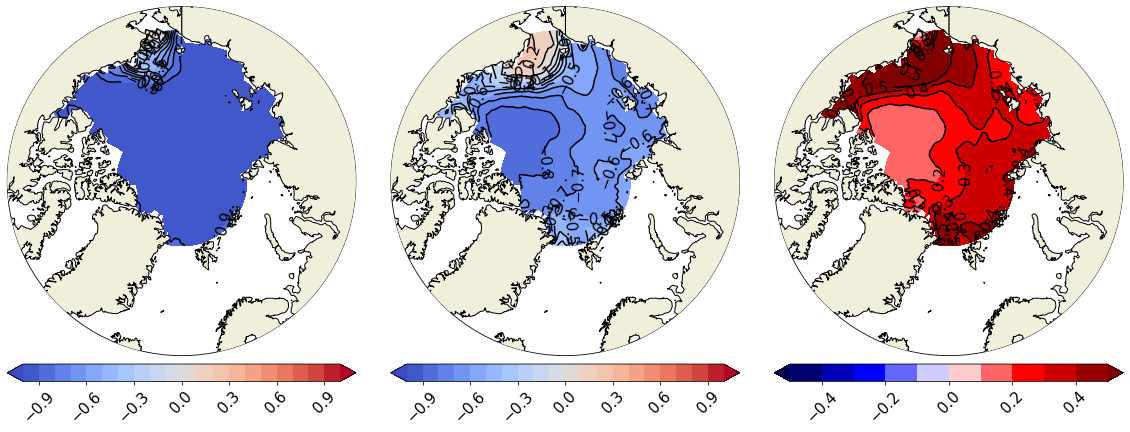

In [58]:
# set units
units = ' '

#Plot each season and percent difference
levels_in = np.arange(-1,1.1,0.1)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-0.5,0.6,0.1)
cmap_diff = plt.cm.get_cmap('seismic')

for ss in season_names[0:1]:
    print('Plotting correlations for '+ss)

    # grab data we want
    corr_u_ice_le = corr_u10_ice_le.sel(season=ss)
    corr_u_ice_rufmod = corr_u10_ice_rufmod.sel(season=ss)
    
    # add cyclic point
    corr_u_ice_le = gvutil.xr_add_cyclic_longitudes(corr_u_ice_le,"lon")
    corr_u_ice_rufmod = gvutil.xr_add_cyclic_longitudes(corr_u_ice_rufmod,"lon")
    
    # calcualate difference
    diff = corr_u_ice_rufmod - corr_u_ice_le

    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'fig_13_legend'
    title = ss+' correlations over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE U10/ICE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(corr_u_ice_le.lon,corr_u_ice_le.lat,
                       corr_u_ice_le,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(corr_u_ice_le.lon,corr_u_ice_le.lat,
                       corr_u_ice_le,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=15, colors='black')
    # title
    #plt.title('CESM2-LE',fontsize=15)

    # Second subplot: Rufmod U10/ICE
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(corr_u_ice_rufmod.lon,corr_u_ice_rufmod.lat,
                       corr_u_ice_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(corr_u_ice_rufmod.lon,corr_u_ice_rufmod.lat,
                       corr_u_ice_rufmod,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=15, colors='black')
    # title
    #plt.title('SMOOTH',fontsize=15)
    
    # Third subplot: difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=15, colors='black')
    # title
    #plt.title('Difference: SMOOTH - CESM2-LE',fontsize=15)
    
    # Finalize figure and save
    #fig.suptitle(title,fontsize=15, y=0.93)  
    fig.subplots_adjust(bottom=0.3,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200) 
